In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import requests
import re
import os
import zipfile
import collections
import urllib.request
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML
from collections import defaultdict
import time
import random

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


2022-12-10 21:44:37.987389: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.4.1
keras version 2.4.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-12-10 21:44:39.290492: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-10 21:44:39.291481: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-10 21:44:39.945753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:e3:00.0 name: NVIDIA A100-SXM4-80GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.17GiB deviceMemoryBandwidth: 1.85TiB/s
2022-12-10 21:44:39.945798: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-10 21:44:39.947745: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-10 21:44:39.947851: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

## Reading the data

In [4]:
%%capture
# !unzip "./all_data/sep_1/data.zip" -d "./temp_data/sep_1/"

In [5]:
# Getting the folder names 
folder_names = glob.glob("./temp_data/sep_1/data/*")

In [6]:
# Getting the data names
data_names = []
for i in folder_names:
    data_names.append(glob.glob(i+"/*.csv"))

## Data Loading

In [7]:
# Datasets to skip 
skip = []

# Labels of the datasets
labels = []

# Data list 
data = []


# Getting the labels and data for each dataset
for i in range(len(data_names)):
    if i in skip:
        continue
    
    for j in range(len(data_names[i])):
        labels.append([data_names[i][j][data_names[i][j].find(".csv")-1]])
        
        # Cleaning data
        df = pd.read_csv(data_names[i][j],skiprows = 1)
        df.drop(columns=df.columns[-1], axis=1,  inplace=True)
        
        data.append(df)

In [8]:
# Changing the labels from int to string
labels = [int(i)-1 for i in np.reshape(labels,(-1,))]

In [9]:
# Targets for sep_1
target = np.array([[-0.314,1.661,0.45],[0,1.661,0.45],[0.314,1.661,0.45],[-0.314,1.347,0.45],[0,1.347,0.45],[0.314,1.347,0.45],[-0.314,1.033,0.45],[0,1.033,0.45],[0.314,1.033,0.45]])

In [10]:
labels_3d = [target[i] for i in labels]

## Adding Features

In [11]:
# Adding the centroid of all the fingers to the data

new_data = []

for idx_1 in range(len(data)):

    
    # Grouped columns for centroid
    grouped_columns_x = data[idx_1].columns[3::3] 
    grouped_columns_y = data[idx_1].columns[4::3]
    grouped_columns_z = data[idx_1].columns[5::3]
    
    # Getting the centroid of the finger points
    cent_x = np.mean(data[idx_1][grouped_columns_x],axis = 1)
    cent_y = np.mean(data[idx_1][grouped_columns_y],axis = 1)
    cent_z = np.mean(data[idx_1][grouped_columns_z],axis = 1)
    
    new_data.append(pd.concat([data[idx_1],cent_x,cent_y,cent_z],axis = 1))
    

## Data Cleaning

In [12]:
# Pulling only the centroid data 
cent_data = [i.iloc[:,-3:] for i in new_data]

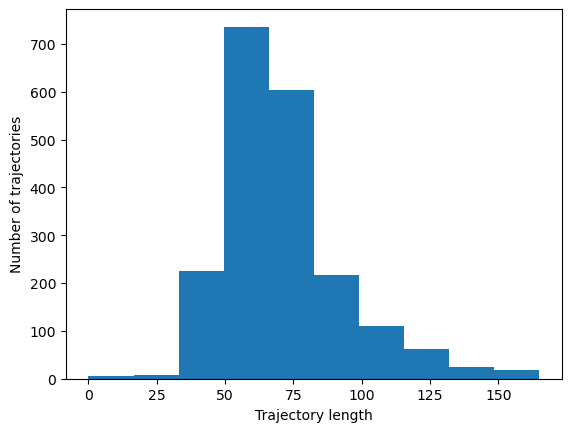

In [13]:
lengths = np.array([len(i) for i in cent_data])
plt.hist(lengths)
plt.xlabel("Trajectory length")
plt.ylabel("Number of trajectories");

In [14]:
# Removing trajectories with <=5 length
idx = np.where(lengths <= 5.)[0]
[labels.pop(j-i) for i,j in enumerate(idx)]
[labels_3d.pop(j-i) for i,j in enumerate(idx)]
[cent_data.pop(j-i) for i,j in enumerate(idx)];

In [15]:
# Checking to see if it worked 
lengths = np.array([len(i) for i in cent_data])
np.where(lengths <= 5.)

(array([], dtype=int64),)

In [16]:
# Train test split
# x_train, x_test, y_train, y_test = train_test_split(cent_data, labels, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(cent_data, labels_3d, test_size=0.2)

## Data Augmentation

In [17]:
x_train_aug = []
for idx,i in enumerate(x_train):
    ch = np.random.choice([0,1],p = [0.3,0.7])

    flag = 0 

    if ch == 0: # Perform data augmentation

        trim = len(i)//2

        if trim >= 5: # Trim if the lengths are greater than 5

            aug = i.head(trim)

        else: # If lengths are not greater than 1, don't trim

            aug = i
    else:
        aug = i


    x_train_aug.append(aug)


In [18]:
# Printing out the lengths after and before augmentation
len(x_train_aug), len(x_train)

(1605, 1605)

## Data Formatting

In [19]:
# Getting the data in the required format for the model
# Creating labels for RNN's output 
y_train = [[dt]*200 for idx,dt in enumerate(y_train)]
y_test = [[dt]*200 for idx,dt in enumerate(y_test)]

In [20]:
# Sequence length is based on data analysis
x_train = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', dtype='float', maxlen=200))
y_train = tf.convert_to_tensor(y_train)

x_test = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', dtype='float', maxlen=200))
y_test = tf.convert_to_tensor(y_test)

In [21]:
# One hot encoding the data for training - not required for label_3d
# y_train = tf.one_hot(y_train, 9, on_value = 1.0, off_value = 0.0)
# y_test = tf.one_hot(y_test, 9, on_value = 1.0, off_value = 0.0)

## Models

### Creating the RNN model

In [22]:


hidden_size= 10
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')


ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN_1(ip_reformed)

RNN_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_2 = RNN_2(h_1)


dense_2 = tf.keras.layers.Dense(9, activation='softmax')
output = dense_2(h_2)

model_RNN = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=tf.keras.optimizers.Adam(1e-2))

### Creating the RNN model - labels_3d

In [22]:
hidden_size= 10
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')


ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN_1(ip_reformed)

RNN_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_2 = RNN_2(h_1)


dense_2 = tf.keras.layers.Dense(3, activation='linear')
output = dense_2(h_2)

model_RNN_3d = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_3d.compile(loss='mse', metrics = ['mse'], optimizer=tf.keras.optimizers.Adam(1e-2))

### Creating the LSTM model

In [23]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h = LSTM(ip_reformed)

dense = tf.keras.layers.Dense(9, activation='softmax')
output = dense(h)

model_LSTM = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_LSTM.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=tf.keras.optimizers.Adam(1e-2))

### Creating the LSTM+RNN model

In [25]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN(ip_reformed)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h_2 = LSTM(h_1)

dense = tf.keras.layers.Dense(9, activation='softmax')
output = dense(h_2)

model_RNN_LSTM = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_LSTM.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=tf.keras.optimizers.Adam(1e-2))

In [23]:
# model_LSTM.summary()
model_RNN_3d.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 200, 3)]          0         
_________________________________________________________________
dense (Dense)                (None, 200, 10)           40        
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200, 10)           210       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 200, 10)           210       
_________________________________________________________________
dense_1 (Dense)              (None, 200, 3)            33        
Total params: 493
Trainable params: 493
Non-trainable params: 0
_________________________________________________________________


In [24]:
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=100,
    restore_best_weights = True
)

In [25]:
history = model_RNN_3d.fit(x_train,y_train, epochs=1000, batch_size=16, validation_split=0.2,callbacks = [callbacks])

2022-12-10 21:53:20.410742: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-10 21:53:20.423337: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


Epoch 1/1000


2022-12-10 21:53:21.375969: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-10 21:55:02.120107: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at cwise_op_gpu_base.cc:89 : Internal: Failed to load in-memory CUBIN: CUDA_ERROR_NO_BINARY_FOR_GPU: no kernel image is available for execution on the device


InternalError:  Failed to load in-memory CUBIN: CUDA_ERROR_NO_BINARY_FOR_GPU: no kernel image is available for execution on the device
	 [[{{node model/simple_rnn/while/body/_1/model/simple_rnn/while/simple_rnn_cell/Tanh}}]] [Op:__inference_train_function_2394]

Function call stack:
train_function


In [162]:
model_LSTM_2.evaluate(x_test,y_test)

13/13 [==============================] - 0s 22ms/step - loss: 0.4737 - accuracy: 0.8289


[0.4736544191837311, 0.8288556933403015]

In [163]:
# model_LSTM.save("/content/drive/MyDrive/Robot perception /Modeling/models/lstm_data_trim.h5")
# model_LSTM.save("/content/drive/MyDrive/Robot perception /Modeling/models/lstm.h5")
model_LSTM_2.save("./models/lstm_2.h5")

In [27]:
# Testing the saved model
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm_data_trim.h5')
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm.h5')
model_load = load_model('./models/sep_1/lstm_rnn.h5')
# model_load = load_model('./models/rnn.h5')
model_load.evaluate(x_test,y_test)

2022-12-10 21:17:01.093535: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-10 21:17:01.105308: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


ValueError: in user code:

    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1185 test_step
        self.compiled_loss(
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /ext3/miniconda3/envs/robot_percp/lib/python3.9/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 200, 3) and (None, 200, 9) are incompatible


In [28]:
model_load.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 200, 3)]          0         
_________________________________________________________________
dense (Dense)                (None, 200, 15)           60        
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200, 15)           465       
_________________________________________________________________
lstm (LSTM)                  (None, 200, 15)           1860      
_________________________________________________________________
dense_1 (Dense)              (None, 200, 9)            144       
Total params: 2,529
Trainable params: 2,529
Non-trainable params: 0
_________________________________________________________________
